In [16]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot, u_darrays as uda, u_met
import pandas as pd

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (30., 30.)
#%matplotlib inline

In [17]:
cd ..

/home/ck


In [18]:
pdf = pkl.load(open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA.p', 'rb'))

In [19]:
pdf_march = pdf.where((pdf.clat>=4.5) & (pdf.clat<=8.5) & (pdf.clon>=-12) & (pdf.clon<=12) &
(pdf.month == 3) & (pdf.year >=2000) & (pdf.year <=2012))
pdf_march = pdf_march.dropna()

In [20]:
pdf_oct = pdf.where((pdf.clat>=4.5) & (pdf.clat<=8.5) & (pdf.clon>=-12) & (pdf.clon<=12) &
(pdf.month == 10) & (pdf.year >=2000) & (pdf.year <=2012))
pdf_oct = pdf_oct.dropna()

In [21]:
era_pl = xr.open_mfdataset('/home/ck/DIR/mymachine/ERA5/pressure_levels/*.nc')
era_srfc = xr.open_mfdataset('/home/ck/DIR/mymachine/ERA5/surface/*.nc')

In [22]:
era_pl = uda.flip_lat(era_pl)
era_srfc = uda.flip_lat(era_srfc)

In [23]:
era_march = pkl.load( open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_march.p', 'rb'))
era_oct = pkl.load( open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_oct.p', 'rb'))

In [24]:
level = era_march.pop('level')
level = era_oct.pop('level')

In [25]:
for k in era_march.keys():
    era_march[k] = era_march[k][0:1841]

In [26]:
for k in era_oct.keys():
    era_oct[k] = era_oct[k][0:2096]

In [27]:
## a clean way of plotting - use matplotlib functions directly:

def draw_cross(data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, twinx=None, **kwargs):
    f=plt.figure(figsize=(15,7))  # this opens a plot window
    ax = f.add_subplot(111)  # this opens a new plot axis
    mapp = ax.contourf(lon, lat, data, **kwargs, extend='both')  # this is the actual plot
    plt.gca().invert_yaxis()
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
        
    if contour is not None:
        cs = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        plt.clabel(cs, inline=1, fontsize=10)
        
    if twinx is not None:
        ax1 = ax.twinx()
        ax1.plot(twinx['x'], twinx['y'], twinx['color'] )
        ax1.set_ylabel(twinx['ylabel'])
        ax1.set_ylim(twinx['ylim'][0], twinx['ylim'][1])
    
    plt.title(title)
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)
    plt.show() 

In [28]:
era_pl['ymonth'] = ('time', [str(m)+'-'+str(h) for (m,h) in zip(era_pl['time.month'].values,era_pl['time.hour'].values)])
grouped='ymonth'
era_pl_cross =  era_pl.groupby(grouped).mean(dim='time')

In [29]:
era_pl_cross.ymonth

<xarray.DataArray 'ymonth' (ymonth: 48)>
array(['1-0', '1-12', '1-18', '1-3', '10-0', '10-12', '10-18', '10-3', '11-0',
       '11-12', '11-18', '11-3', '12-0', '12-12', '12-18', '12-3', '2-0',
       '2-12', '2-18', '2-3', '3-0', '3-12', '3-18', '3-3', '4-0', '4-12',
       '4-18', '4-3', '5-0', '5-12', '5-18', '5-3', '6-0', '6-12', '6-18',
       '6-3', '7-0', '7-12', '7-18', '7-3', '8-0', '8-12', '8-18', '8-3',
       '9-0', '9-12', '9-18', '9-3'], dtype=object)
Coordinates:
  * ymonth   (ymonth) object '1-0' '1-12' '1-18' '1-3' ... '9-12' '9-18' '9-3'

In [63]:
cross_march = era_pl_cross.sel(ymonth='2-12', longitude=slice(-10,10), latitude=slice(4,20))
cross_oct = era_pl_cross.sel(ymonth='10-12', longitude=slice(-10,10), latitude=slice(4,20))

In [64]:
ccross_march = cross_march.mean('longitude')
ccross_oct = cross_oct.mean('longitude')

In [65]:
cross_march['t']

<xarray.DataArray 't' (level: 19, latitude: 65, longitude: 81)>
dask.array<shape=(19, 65, 81), dtype=float32, chunksize=(19, 65, 81)>
Coordinates:
  * longitude  (longitude) float32 -10.0 -9.75 -9.5 -9.25 ... 9.25 9.5 9.75 10.0
  * latitude   (latitude) float32 4.0 4.25 4.5 4.75 ... 19.25 19.5 19.75 20.0
  * level      (level) int32 200 250 300 350 400 450 ... 850 875 900 925 950 975
    ymonth     <U4 '2-12'

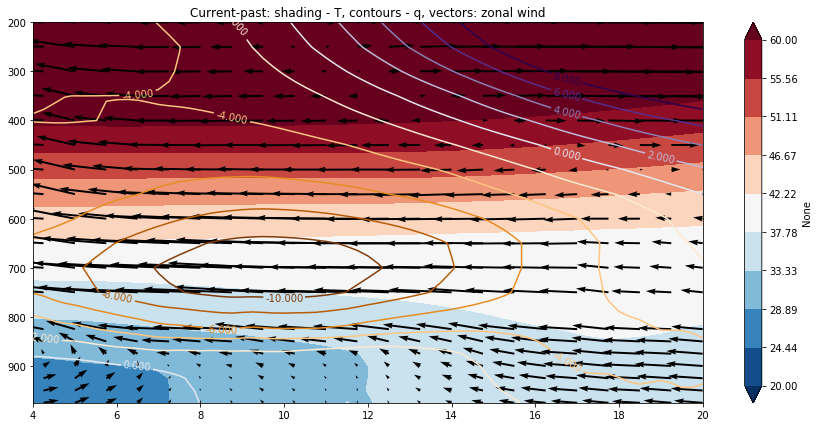

In [66]:
# "current zonal wind" wind vectors
uano = ccross_oct['u']
wano = ccross_oct['w']*(-10)  # multiplied by 10 since vertical component is very small compared to horizontal one
st=3
sarrow = 1
xquiv = ccross_march.latitude[sarrow::st]
yquiv = ccross_march.level

uu = (uano)[::, sarrow::st]  
ww = (wano)[::, sarrow::st]

qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : ww, 'scale' : 80}

# temperature and moisture check
data = (ccross_oct['u'])
data2 = u_met.theta(ccross_oct.level.values, ccross_oct['t'].values-273.15)
contour = {'data' : data, 'x' : ccross_oct.latitude, 'y' : ccross_oct.level, 'levels' : np.arange(-10,10,2), 'cmap' : 'PuOr'}
draw_cross(data2, ccross_oct.latitude, ccross_oct.level, cmap='RdBu_r', 
           levels=np.linspace(20,60,10), quiver=qin, contour=contour, title='Current-past: shading - T, contours - q, vectors: zonal wind')

In [67]:
ccross_march['t'].values-273.15

array([[-53.836746, -53.84651 , -53.85898 , ..., -54.318665, -54.317413,
        -54.31726 ],
       [-41.662384, -41.68141 , -41.699326, ..., -44.161377, -44.261368,
        -44.367447],
       [-31.504929, -31.522797, -31.542618, ..., -35.359436, -35.51419 ,
        -35.674545],
       ...,
       [ 21.62384 ,  21.742706,  21.827637, ...,  20.467926,  20.285858,
         20.127747],
       [ 22.777008,  22.90625 ,  23.062714, ...,  22.11081 ,  21.966675,
         21.815125],
       [ 24.441284,  24.549622,  24.740967, ...,  23.892853,  23.7323  ,
         23.570038]], dtype=float32)

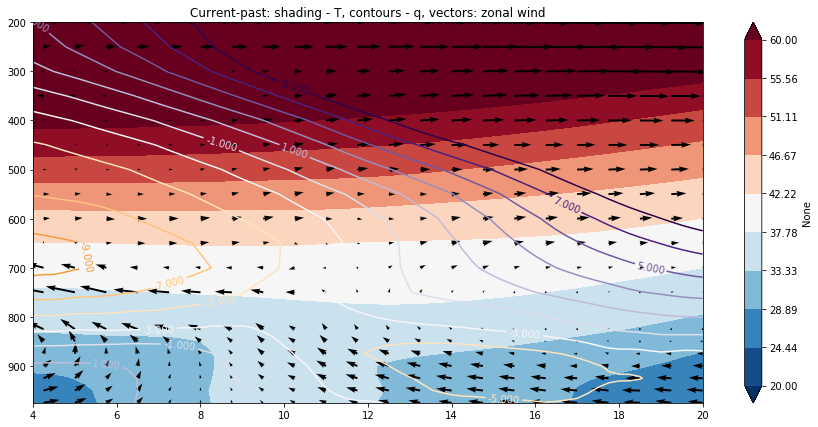

In [69]:
# "current zonal wind" wind vectors
uano = ccross_march['u']
wano = ccross_march['w']*(-10)  # multiplied by 10 since vertical component is very small compared to horizontal one
vano = ccross_march['v']
st=3
sarrow = 1
xquiv = ccross_march.latitude[sarrow::st]
yquiv = ccross_march.level

uu = (vano)[::, sarrow::st]  
ww = (wano)[::, sarrow::st]

qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : ww, 'scale' : 80}

# temperature and moisture check
data = (ccross_march['u'])
data2 = u_met.theta(ccross_march.level.values, ccross_march['t'].values-273.15)
contour = {'data' : data, 'x' : ccross_march.latitude, 'y' : ccross_march.level, 'levels' : np.arange(-15,10,2), 'cmap' : 'PuOr'}
draw_cross(data2, ccross_march.latitude, ccross_march.level, cmap='RdBu_r', 
           levels=np.linspace(20,60,10), quiver=qin, contour=contour, title='Current-past: shading - T, contours - q, vectors: zonal wind')

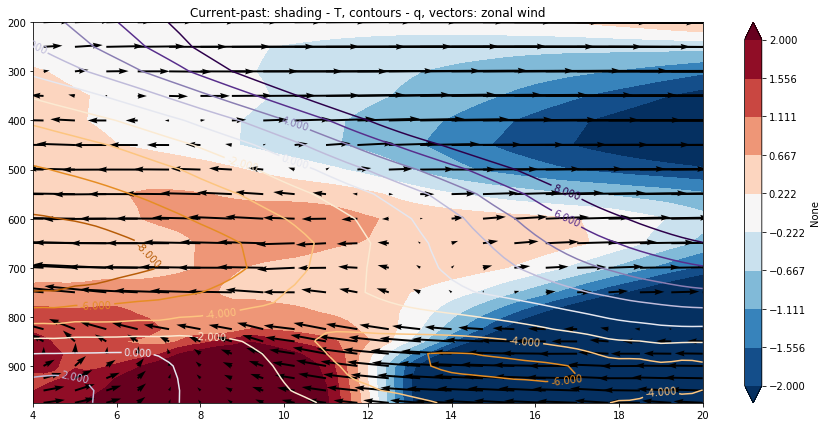

In [62]:
# "current zonal wind" wind vectors
uano = ccross_march['u']
wano = ccross_march['w']*(-10)  # multiplied by 10 since vertical component is very small compared to horizontal one
st=3
sarrow = 1
xquiv = ccross_march.latitude[sarrow::st]
yquiv = ccross_march.level

uu = (uano)[::, sarrow::st]  
ww = (wano)[::, sarrow::st]

qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : ww, 'scale' : 80}

# temperature and moisture check
data = (ccross_march['u'])
contour = {'data' : data, 'x' : ccross_march.latitude, 'y' : ccross_march.level, 'levels' : np.arange(-10,10,2), 'cmap' : 'PuOr'}
draw_cross((ccross_march['t']-ccross_oct['t']), ccross_march.latitude, ccross_march.level, cmap='RdBu_r', 
           levels=np.linspace(-2,2,10), quiver=qin, contour=contour, title='Current-past: shading - T, contours - q, vectors: zonal wind')

In [52]:
## a clean way of plotting - use matplotlib functions directly:

def draw_map(data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, **kwargs):
    f=plt.figure(figsize=(15,7))  # this opens a plot window
    ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
    mapp = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), **kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        
    
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    plt.title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)
    plt.show()   

In [53]:
(cross_march)['u']

<xarray.DataArray 'u' (level: 19, latitude: 65, longitude: 81)>
dask.array<shape=(19, 65, 81), dtype=float32, chunksize=(19, 65, 81)>
Coordinates:
  * longitude  (longitude) float32 -10.0 -9.75 -9.5 -9.25 ... 9.25 9.5 9.75 10.0
  * latitude   (latitude) float32 4.0 4.25 4.5 4.75 ... 19.25 19.5 19.75 20.0
  * level      (level) int32 200 250 300 350 400 450 ... 850 875 900 925 950 975
    ymonth     <U4 '8-12'

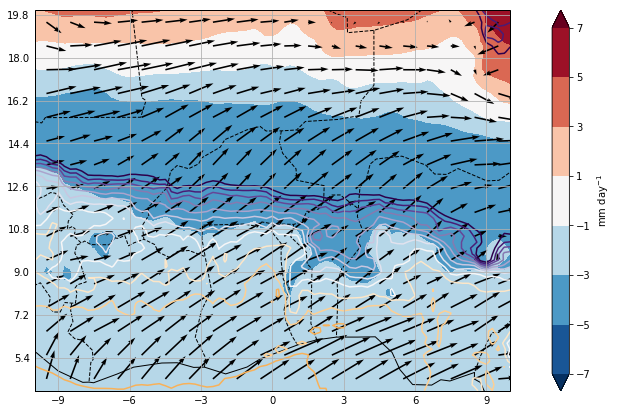

In [54]:
lon=cross_march.longitude
lat=cross_march.latitude
map_cross_march = cross_march.sel(level=925)
map_cross_oct = cross_oct.sel(level=925)
data=map_cross_march['t']-map_cross_oct['t']
data2=map_cross_march['q']-map_cross_oct['q']
title=''

contour = {'data' : data2*1000, 'x' : lon, 'y' : lat, 'levels' : np.arange(-3,3,0.4), 'cmap' : 'PuOr'}

# preparation of wind vector data in plot
st=4
sarrow = 2
xquiv = map_cross_march.longitude[sarrow::st]
yquiv = map_cross_march.latitude[sarrow::st]

uu = (map_cross_march['u'])[sarrow::st, sarrow::st]
vv = (map_cross_march['v'])[sarrow::st, sarrow::st]


qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : vv, 'scale' : 70}

draw_map(data, lon, lat, title=title, levels=np.linspace(-7,7,8), extend='both', quiver=qin, cmap='RdBu_r', contour=contour, cbar_label= 'mm day$^{-1}$')


In [55]:
def linear_trend_lingress_2d(x, nb_missing=None, sig=None, method=None):
    
    
    # stack lat and lon into a single dimension called allpoints
    datastacked = x.stack(allpoints=['latitude', 'level'])

    # apply the function over allpoints to calculate the trend at each point
    print('Entering trend calc')

    alpha = 0.05
    # NaNs means there is not enough data, slope = 0 means there is no significant trend.
    if method=='mk':
        dtrend = datastacked.groupby('allpoints').apply(uda.linear_trend_mk, alpha=alpha, eps=0.0001,nb_missing=10)
        dtrend = dtrend.unstack('allpoints')
        if sig:
            (dtrend['slope'].values)[dtrend['ind'].values==0] = 0

    # NaNs means there is not enough data, slope = 0 means there is no significant trend.
    if method=='polyfit':
        dtrend = datastacked.groupby('allpoints').apply(uda.linear_trend_lingress,nb_missing=10)
        dtrend = dtrend.unstack('allpoints')

        if sig:
            (dtrend['slope'].values)[dtrend['pval'].values > alpha] = np.nan
            
    return dtrend['slope']

In [87]:
era_srfc = xr.open_dataset(cnst.ERA_MONTHLY_SRFC)
era_pl = xr.open_dataset(cnst.ERA_MONTHLY_PL)
ccover = xr.open_dataset(cnst.GRIDSAT + 'aggs/gridsat_WA_-70_monthly_count.nc')
era_srfc = uda.flip_lat(era_srfc)
era_pl = uda.flip_lat(era_pl)
era_trend = era_pl.sel(longitude=slice(-10,10), latitude=slice(4,20), level=slice(200,925)).squeeze().mean('longitude')

In [88]:
def trends_month(var):
    
    utrend = (era_trend[var])[(era_trend['time.year']>1982)].groupby('time.month').apply(linear_trend_lingress_2d,nb_missing=10, method='mk')*10
    
    return utrend

In [89]:
utrend = trends_month('t')

Entering trend calc
Entering trend calc
Entering trend calc
Entering trend calc
Entering trend calc
Entering trend calc
Entering trend calc
Entering trend calc
Entering trend calc
Entering trend calc
Entering trend calc
Entering trend calc


In [93]:
ccross_march = cross_march.mean('longitude')
ccross_oct = cross_oct.mean('longitude')
ccross_march['t'].values = u_met.theta(ccross_march.level.values, ccross_march['t'].values-273.15)

In [94]:
utrend

<xarray.DataArray 'slope' (month: 12, level: 16, latitude: 21)>
array([[[ 1.328607e-01,  1.356456e-01, ...,  2.368253e-01,  2.498322e-01],
        [ 3.110963e-01,  3.133256e-01, ...,  3.579069e-01,  3.476832e-01],
        ...,
        [ 1.650719e-01,  1.477577e-01, ..., -1.268864e-02,  4.659957e-03],
        [ 1.862761e-01,  1.760384e-01, ...,  2.098806e-02,  4.814793e-02]],

       [[ 1.300725e-01,  1.377932e-01, ...,  4.305631e-01,  4.422398e-01],
        [ 3.375626e-01,  3.387907e-01, ...,  5.484644e-01,  5.626476e-01],
        ...,
        [ 1.474275e-01,  1.059498e-01, ...,  1.559635e-01,  1.388612e-01],
        [ 1.487389e-01,  1.103346e-01, ...,  1.426760e-01,  1.295491e-01]],

       ...,

       [[ 1.850886e-01,  1.903404e-01, ...,  2.912965e-01,  2.916931e-01],
        [ 3.915500e-01,  3.988353e-01, ...,  4.018814e-01,  3.945066e-01],
        ...,
        [ 1.525678e-01,  1.374463e-01, ...,  1.052315e-01,  1.016694e-01],
        [ 1.635867e-01,  1.574396e-01, ...,  1.044042e-

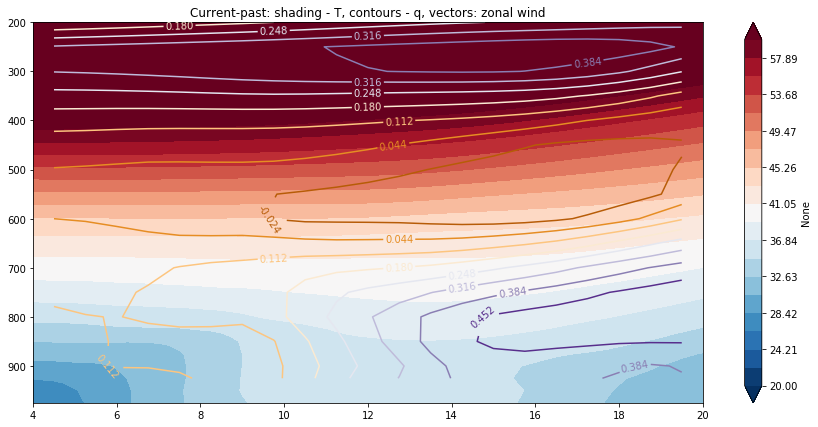

In [95]:
# temperature and moisture check
data = utrend.sel(month=3) #(ccross_march['t'])
contour = {'data' : data, 'x' : utrend.latitude, 'y' : utrend.level, 'levels' : np.linspace(data.min(),data.max(),10), 'cmap' : 'PuOr'}
draw_cross((ccross_march['t']), ccross_march.latitude, ccross_march.level, cmap='RdBu_r', contour=contour,
           levels=np.linspace(20,60,20), title='Current-past: shading - T, contours - q, vectors: zonal wind')